In [ ]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path

In [2]:
# Defining number of input parameters and number of outputs in the feature 
num_samples = 150
num_harmonics = 20
num_input_parameter = 35

#### Loading screening data data

In [3]:
""" This section of the code does the following tasks
1. Creating input and output training data for building surrogate models
2. The input data is stored in master_parameter_input array with shape [num_samples,num_parameters]
3. The output data is stored in master_parameter_output array with shape [num samples, 4 x num_harmonics]
"""
# Fetching project from signac workspace

# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )
else:
    print("No data file exists!")


print(np.shape(master_parameter_input_n))
print(np.shape(master_feature_output))


(150, 35)
(150, 80)


##### Output data preprocessing - Feature reduction using PCA

In [4]:
""" A) his section of code proejects the feature space into lower dimensions using PCA
b) Scikit learn was first used to normalize the data and then take principal components
c) Varaince captured in the principal components is also estimated
d) Further the section plots the correlations between KECM and different principal components
"""
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Storing the feature output data in x (Not save as x as x is for inputs)
x = master_feature_output
# Normalizing the data
x = StandardScaler().fit_transform(x)
# Defining number of components in PCA
pca = PCA(n_components=8)
# Using scikit learn to calculate PCs
principalComponents = pca.fit_transform(x)
# Calculating weights
weights = pca.components_
# Variance explained in the principal components
print(pca.explained_variance_ratio_)


[0.21895301 0.17323367 0.11290526 0.09812456 0.08294328 0.05576723
 0.04099771 0.03003538]


#### Input data preprocesseing : Parameter selection and data normaization

In [5]:
""" TRSAINING AND TESTING DATA FOR GPR MODEL
    a) This section of the code prepares the training data for the GPR model.
    b) Parameter that were varied during the LHS rae chosen as the input variables to the model.
    c) Output training data are the PCs of the PCs of the EFD features
    d) A split is carried out in the inut and output data to create a training and testing dataset for model
    e) Definition of parameters varied in LHS
       i) param_2 - T_squamous_basal 
       ii) param_5 - T_cuboidal_basal
       iii) param_8 - T_columnar_basal
       iv) param_18 - k_columnar_basal
       v) param_19 - k_columnar_apical
       vi) param_20 - k_columnar_lateral
       vii) param_34 - k_ecm
"""

# Transforming input parameter data to log scale
master_parameter_input = np.log(master_parameter_input_n)
# Number of parameters in the Latin Hypercube sampling
num_parameters_LHS = 7
param_index = [1, 4, 7, 17, 18, 19, 33]
split_size = 110
# Initializing the training data
train_x_numpy = np.zeros((num_samples, num_parameters_LHS))
# Getting the parameter values from master_parameter_input
for i in range(num_parameters_LHS):
    train_x_numpy[:,i] = master_parameter_input[:,param_index[i]]

# Normalizing the data around mean
train_x_numpy = StandardScaler().fit_transform(train_x_numpy)

C:\Users\Nilay\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


#### GPR modeling

In [6]:
""" Importing librarie
"""

import math
import torch
import gpytorch
from matplotlib import pyplot as plt
""" Loading LBFGS library
"""
from LBFGS import FullBatchLBFGS

%matplotlib inline
%load_ext autoreload
%autoreload 2

""" This section of the code calculates the likelihood based on RBF Kernel
    ExactGPModels are defined 
    A) Model 1: Input: Parameters, Output: PC1
    B) Model 2: Input: Parameters, Output: PC2
    
    Code for GP regression derived from GpyTorch example: 
    https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
"""

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        """ Defining a RBF kernel """
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = 7))
        """ Defining a Matern kernel """
        # mu is the smoothness parameter
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))
        """ Defining a cosine Kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())
        """ Defining a linear kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
        """ Defining a periodic Kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        """ Defining piecewise polunomial Kernel"""
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PiecewisePolynomialKernel())
        """ Defining a RQ Kernel """
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Iter 1/1000 - Loss: 6.469
Iter 2/1000 - Loss: 6.003
Iter 3/1000 - Loss: 5.595
Iter 4/1000 - Loss: 5.237
Iter 5/1000 - Loss: 4.925
Iter 6/1000 - Loss: 4.653
Iter 7/1000 - Loss: 4.417
Iter 8/1000 - Loss: 4.211
Iter 9/1000 - Loss: 4.031
Iter 10/1000 - Loss: 3.874
Iter 11/1000 - Loss: 3.736
Iter 12/1000 - Loss: 3.615
Iter 13/1000 - Loss: 3.508
Iter 14/1000 - Loss: 3.413
Iter 15/1000 - Loss: 3.330
Iter 16/1000 - Loss: 3.256
Iter 17/1000 - Loss: 3.191
Iter 18/1000 - Loss: 3.133
Iter 19/1000 - Loss: 3.083
Iter 20/1000 - Loss: 3.039
Iter 21/1000 - Loss: 3.000
Iter 22/1000 - Loss: 2.966
Iter 23/1000 - Loss: 2.937
Iter 24/1000 - Loss: 2.911
Iter 25/1000 - Loss: 2.889
Iter 26/1000 - Loss: 2.870
Iter 27/1000 - Loss: 2.852
Iter 28/1000 - Loss: 2.837
Iter 29/1000 - Loss: 2.824
Iter 30/1000 - Loss: 2.811
Iter 31/1000 - Loss: 2.800
Iter 32/1000 - Loss: 2.789
Iter 33/1000 - Loss: 2.779
Iter 34/1000 - Loss: 2.769
Iter 35/1000 - Loss: 2.760
Iter 36/1000 - Loss: 2.751
Iter 37/1000 - Loss: 2.743
Iter 38/10

Iter 297/1000 - Loss: 2.467
Iter 298/1000 - Loss: 2.467
Iter 299/1000 - Loss: 2.466
Iter 300/1000 - Loss: 2.466
Iter 301/1000 - Loss: 2.466
Iter 302/1000 - Loss: 2.466
Iter 303/1000 - Loss: 2.466
Iter 304/1000 - Loss: 2.465
Iter 305/1000 - Loss: 2.465
Iter 306/1000 - Loss: 2.465
Iter 307/1000 - Loss: 2.465
Iter 308/1000 - Loss: 2.465
Iter 309/1000 - Loss: 2.464
Iter 310/1000 - Loss: 2.464
Iter 311/1000 - Loss: 2.464
Iter 312/1000 - Loss: 2.464
Iter 313/1000 - Loss: 2.463
Iter 314/1000 - Loss: 2.463
Iter 315/1000 - Loss: 2.463
Iter 316/1000 - Loss: 2.463
Iter 317/1000 - Loss: 2.463
Iter 318/1000 - Loss: 2.462
Iter 319/1000 - Loss: 2.462
Iter 320/1000 - Loss: 2.462
Iter 321/1000 - Loss: 2.462
Iter 322/1000 - Loss: 2.462
Iter 323/1000 - Loss: 2.461
Iter 324/1000 - Loss: 2.461
Iter 325/1000 - Loss: 2.461
Iter 326/1000 - Loss: 2.461
Iter 327/1000 - Loss: 2.461
Iter 328/1000 - Loss: 2.460
Iter 329/1000 - Loss: 2.460
Iter 330/1000 - Loss: 2.460
Iter 331/1000 - Loss: 2.460
Iter 332/1000 - Loss

Iter 589/1000 - Loss: 2.410
Iter 590/1000 - Loss: 2.410
Iter 591/1000 - Loss: 2.409
Iter 592/1000 - Loss: 2.409
Iter 593/1000 - Loss: 2.409
Iter 594/1000 - Loss: 2.409
Iter 595/1000 - Loss: 2.409
Iter 596/1000 - Loss: 2.408
Iter 597/1000 - Loss: 2.408
Iter 598/1000 - Loss: 2.408
Iter 599/1000 - Loss: 2.408
Iter 600/1000 - Loss: 2.408
Iter 601/1000 - Loss: 2.407
Iter 602/1000 - Loss: 2.407
Iter 603/1000 - Loss: 2.407
Iter 604/1000 - Loss: 2.407
Iter 605/1000 - Loss: 2.407
Iter 606/1000 - Loss: 2.406
Iter 607/1000 - Loss: 2.406
Iter 608/1000 - Loss: 2.406
Iter 609/1000 - Loss: 2.406
Iter 610/1000 - Loss: 2.406
Iter 611/1000 - Loss: 2.405
Iter 612/1000 - Loss: 2.405
Iter 613/1000 - Loss: 2.405
Iter 614/1000 - Loss: 2.405
Iter 615/1000 - Loss: 2.405
Iter 616/1000 - Loss: 2.404
Iter 617/1000 - Loss: 2.404
Iter 618/1000 - Loss: 2.404
Iter 619/1000 - Loss: 2.404
Iter 620/1000 - Loss: 2.404
Iter 621/1000 - Loss: 2.404
Iter 622/1000 - Loss: 2.403
Iter 623/1000 - Loss: 2.403
Iter 624/1000 - Loss

Iter 881/1000 - Loss: 2.369
Iter 882/1000 - Loss: 2.369
Iter 883/1000 - Loss: 2.369
Iter 884/1000 - Loss: 2.369
Iter 885/1000 - Loss: 2.369
Iter 886/1000 - Loss: 2.369
Iter 887/1000 - Loss: 2.369
Iter 888/1000 - Loss: 2.369
Iter 889/1000 - Loss: 2.369
Iter 890/1000 - Loss: 2.369
Iter 891/1000 - Loss: 2.369
Iter 892/1000 - Loss: 2.369
Iter 893/1000 - Loss: 2.368
Iter 894/1000 - Loss: 2.368
Iter 895/1000 - Loss: 2.368
Iter 896/1000 - Loss: 2.368
Iter 897/1000 - Loss: 2.368
Iter 898/1000 - Loss: 2.368
Iter 899/1000 - Loss: 2.368
Iter 900/1000 - Loss: 2.368
Iter 901/1000 - Loss: 2.368
Iter 902/1000 - Loss: 2.368
Iter 903/1000 - Loss: 2.368
Iter 904/1000 - Loss: 2.368
Iter 905/1000 - Loss: 2.368
Iter 906/1000 - Loss: 2.368
Iter 907/1000 - Loss: 2.368
Iter 908/1000 - Loss: 2.367
Iter 909/1000 - Loss: 2.367
Iter 910/1000 - Loss: 2.367
Iter 911/1000 - Loss: 2.367
Iter 912/1000 - Loss: 2.367
Iter 913/1000 - Loss: 2.367
Iter 914/1000 - Loss: 2.367
Iter 915/1000 - Loss: 2.367
Iter 916/1000 - Loss

Iter 177/1000 - Loss: 2.869
Iter 178/1000 - Loss: 2.867
Iter 179/1000 - Loss: 2.865
Iter 180/1000 - Loss: 2.863
Iter 181/1000 - Loss: 2.861
Iter 182/1000 - Loss: 2.859
Iter 183/1000 - Loss: 2.857
Iter 184/1000 - Loss: 2.855
Iter 185/1000 - Loss: 2.854
Iter 186/1000 - Loss: 2.852
Iter 187/1000 - Loss: 2.850
Iter 188/1000 - Loss: 2.848
Iter 189/1000 - Loss: 2.847
Iter 190/1000 - Loss: 2.845
Iter 191/1000 - Loss: 2.844
Iter 192/1000 - Loss: 2.842
Iter 193/1000 - Loss: 2.840
Iter 194/1000 - Loss: 2.839
Iter 195/1000 - Loss: 2.837
Iter 196/1000 - Loss: 2.836
Iter 197/1000 - Loss: 2.835
Iter 198/1000 - Loss: 2.833
Iter 199/1000 - Loss: 2.832
Iter 200/1000 - Loss: 2.830
Iter 201/1000 - Loss: 2.829
Iter 202/1000 - Loss: 2.828
Iter 203/1000 - Loss: 2.826
Iter 204/1000 - Loss: 2.825
Iter 205/1000 - Loss: 2.824
Iter 206/1000 - Loss: 2.822
Iter 207/1000 - Loss: 2.821
Iter 208/1000 - Loss: 2.820
Iter 209/1000 - Loss: 2.819
Iter 210/1000 - Loss: 2.818
Iter 211/1000 - Loss: 2.816
Iter 212/1000 - Loss

Iter 469/1000 - Loss: 2.696
Iter 470/1000 - Loss: 2.696
Iter 471/1000 - Loss: 2.695
Iter 472/1000 - Loss: 2.695
Iter 473/1000 - Loss: 2.695
Iter 474/1000 - Loss: 2.695
Iter 475/1000 - Loss: 2.695
Iter 476/1000 - Loss: 2.694
Iter 477/1000 - Loss: 2.694
Iter 478/1000 - Loss: 2.694
Iter 479/1000 - Loss: 2.694
Iter 480/1000 - Loss: 2.694
Iter 481/1000 - Loss: 2.693
Iter 482/1000 - Loss: 2.693
Iter 483/1000 - Loss: 2.693
Iter 484/1000 - Loss: 2.693
Iter 485/1000 - Loss: 2.693
Iter 486/1000 - Loss: 2.693
Iter 487/1000 - Loss: 2.692
Iter 488/1000 - Loss: 2.692
Iter 489/1000 - Loss: 2.692
Iter 490/1000 - Loss: 2.692
Iter 491/1000 - Loss: 2.692
Iter 492/1000 - Loss: 2.691
Iter 493/1000 - Loss: 2.691
Iter 494/1000 - Loss: 2.691
Iter 495/1000 - Loss: 2.691
Iter 496/1000 - Loss: 2.691
Iter 497/1000 - Loss: 2.691
Iter 498/1000 - Loss: 2.690
Iter 499/1000 - Loss: 2.690
Iter 500/1000 - Loss: 2.690
Iter 501/1000 - Loss: 2.690
Iter 502/1000 - Loss: 2.690
Iter 503/1000 - Loss: 2.690
Iter 504/1000 - Loss

Iter 761/1000 - Loss: 2.662
Iter 762/1000 - Loss: 2.662
Iter 763/1000 - Loss: 2.662
Iter 764/1000 - Loss: 2.662
Iter 765/1000 - Loss: 2.662
Iter 766/1000 - Loss: 2.662
Iter 767/1000 - Loss: 2.662
Iter 768/1000 - Loss: 2.662
Iter 769/1000 - Loss: 2.662
Iter 770/1000 - Loss: 2.662
Iter 771/1000 - Loss: 2.662
Iter 772/1000 - Loss: 2.662
Iter 773/1000 - Loss: 2.662
Iter 774/1000 - Loss: 2.662
Iter 775/1000 - Loss: 2.661
Iter 776/1000 - Loss: 2.661
Iter 777/1000 - Loss: 2.661
Iter 778/1000 - Loss: 2.661
Iter 779/1000 - Loss: 2.661
Iter 780/1000 - Loss: 2.661
Iter 781/1000 - Loss: 2.661
Iter 782/1000 - Loss: 2.661
Iter 783/1000 - Loss: 2.661
Iter 784/1000 - Loss: 2.661
Iter 785/1000 - Loss: 2.661
Iter 786/1000 - Loss: 2.661
Iter 787/1000 - Loss: 2.661
Iter 788/1000 - Loss: 2.661
Iter 789/1000 - Loss: 2.661
Iter 790/1000 - Loss: 2.661
Iter 791/1000 - Loss: 2.660
Iter 792/1000 - Loss: 2.660
Iter 793/1000 - Loss: 2.660
Iter 794/1000 - Loss: 2.660
Iter 795/1000 - Loss: 2.660
Iter 796/1000 - Loss

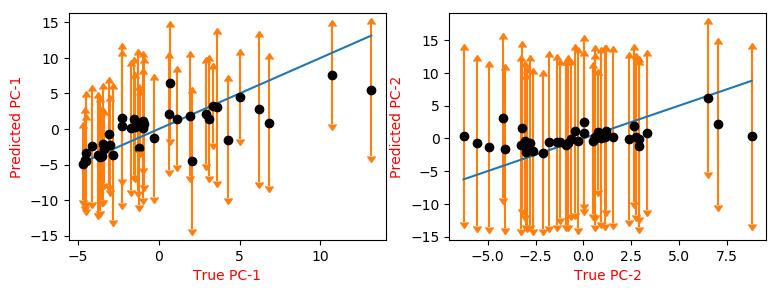

In [7]:
""" To do: 1. Calculate the final value of the hyperparameters 
        2. How are the hyperparameters initaialized? Print out the initialvalues of the hyperparameters
        3. Find an example of using LBFGS in GPyTorch and inmplement it in our code. The adam optimizer may not be doing a good job.
        
"""

# Defines the number of samples used for training and testing the gpr model
split_size = 110
num_pc_analyzed = 2

from matplotlib.pyplot import figure
figure(figsize=(9, 3), dpi=100)

""" Looping through the first two principal components"""

for j in range(num_pc_analyzed):
    """ Training data """
    # Converting numpy array to tensor
    train_x = torch.from_numpy(train_x_numpy[:split_size,:])
    # Converting the output training data to numpy array
    train_y = torch.from_numpy(principalComponents[:split_size,j])
    """ Testing data """
    test_x = torch.from_numpy(train_x_numpy[split_size:num_samples,:])
    test_y = principalComponents[split_size:num_samples,j]
    # Defining models for GPR
    model = ExactGPModel(train_x, train_y, likelihood)
    
    hypers = {
        'covar_module.base_kernel.lengthscale': torch.tensor([[2, 2, 2, 2, 2, 2, 2]]),
    }
    model.initialize(**hypers)
        
    """ Training the GPR model"""
    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else 1000
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    # 
    #optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    training_iter = 1000
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (
            i + 1, training_iter, loss.item(),

        ))
        optimizer.step()
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        
    with torch.no_grad():
        # Calculating upper and lower bounds of model predictions
        lower, upper = observed_pred.confidence_region()
        # converting upper and lower bound prediction sto numpy array
        lower_numpy = lower.numpy()
        upper_numpy = upper.numpy()
        # Claculating mean prediction
        output_model_predictions = observed_pred.mean.numpy()
        # fetching actual output data
        original_output = test_y
        
    # Calculating total error in predictions 
    error_prediction = np.subtract(upper_numpy, lower_numpy)
    # Discretizing coordinate system for updating the parietal_plots
    x_par = np.linspace(np.amin(original_output),np.amax(original_output), num = 100)
    # Plotting the parietal line y = x
    plt.subplot(1,2,j+1)
    plt.plot(x_par, x_par)
    # Plotting the output predictions against known output value
    plt.plot(original_output, output_model_predictions, 'o', color='black')
    # Plotting the errorbars
    plt.errorbar(original_output, output_model_predictions,
                yerr = error_prediction, lolims = lower_numpy, uplims = upper_numpy, linestyle = "None")
    plt.xlabel("True PC-" + str(j+1),color="red")
    plt.ylabel("Predicted PC-" + str(j+1),color="red")
        
plt.show()            

In [ ]:
print(model.covar_module.base_kernel.lengthscale)